# Objectives of the Notebook

In this exercise we will show how to compare strong motion data against some selected models using the GMPE-SMTK software.

The data are taken from the Engineering Strong Motion Database (http://esm.mi.ingv.it)

### Some preliminaries ... import the tools

In [1]:
%matplotlib inline
# Standard library Python
import h5py, os, cPickle

# Numerical plotting library
import numpy as np
import matplotlib.pyplot as plt

# GMPE-SMTK tools
import smtk.residuals.gmpe_residuals as res
import smtk.residuals.residual_plotter as rspl
from smtk.strong_motion_selector import SMRecordSelector,rank_sites_by_record_count
import smtk.database_visualiser as vis

# For plotting later
import matplotlib
matplotlib.rcParams["text.usetex"] = True
from cycler import cycler

### Connect to and load data from the database

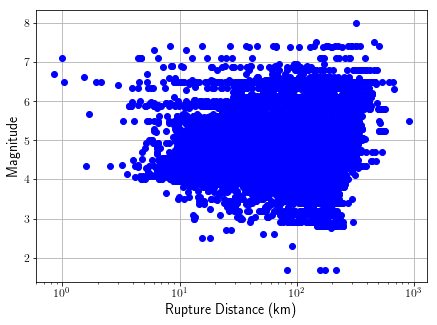

In [2]:
# Path to the database file
dbfile = "epos_flatfile_v5/metadatafile.pkl"
# Load the database
db1 = cPickle.load(open(dbfile, "r"))
# Visualise the composition in terms of magnitude and distance
vis.db_magnitude_distance(db1, "rrup")

## Preliminary Filtering to Limit to Magnitude, Depth and Vs30

Not all of the database is appropriate for comparison against Ground Shaking Intensity Models (GSIMs). For looking at active shallow GSIMs we will make the following restrictions:

i. $M_W \geq 3.0$

ii. Depth $\leq$ 30 km

iii. $V_{S30}$ > 100.0 m/s 

These selections will also exclude records with missing attributes.

In [3]:
# Select above Mw 3.0
selector1 = SMRecordSelector(db1)
db2 = selector1.select_within_magnitude(3.0, 10.0, as_db=True)

# Select records with depths between 0 and 30 km
selector2 = SMRecordSelector(db2)
db3 = selector2.select_within_depths(0.0, 30.0, as_db=True)

# Select records with a Vs30 greater than 100 m/s
selector3 = SMRecordSelector(db3)
db4 = selector3.select_within_vs30_range(100, np.inf, as_db=True)


### Finally, just look at one subset of the database: records from Switzerland

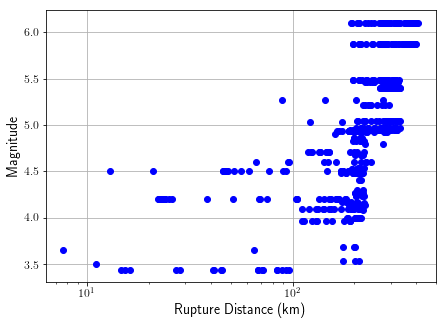

The database contains 536 records


In [4]:
# Finally - select just the records in Switzerland
selector4 = SMRecordSelector(db4)
swiss_db = selector3.select_by_station_country("Switzerland", as_db=True)
vis.db_magnitude_distance(swiss_db, "rrup")
print("The database contains %g records" % len(swiss_db))

### Calculate Residuals for Various Shallow GMPEs

We will compare the data against models for 4 GSIMs all considered appropriate for shallow crustal earthquakes:

i. Akkar et al., 2014 (European & Middle East Data)

ii. Bindi et al., 2014 (European & Middle East Data)

iii. Cauzzi et al., 2014 (Japanese Data)

iv. Chiou & Youngs, 2014 (Global Data - skewed toward California)

For the intensity measures we include PGA, Sa(0.1 s), Sa(0.2 s), Sa(0.3 s), Sa(0.5 s), Sa(0.75 s), Sa(1.0 s) and Sa(2.0 s)

In [5]:
gsims = ["AkkarEtAlRjb2014", "BindiEtAl2014Rjb", "CauzziEtAl2014",  "ChiouYoungs2014"]

imts = ["PGA", "SA(0.1)", "SA(0.2)", "SA(0.3)", "SA(0.5)", "SA(0.75)", "SA(1.0)", "SA(2.0)"]

#### Calculate the residuals

In [6]:
# Setup the tool with the lists of GSIMs and IMTs
llh = res.LLH(gsims, imts)
# Get the residuals for the models from the database
llh.get_residuals(swiss_db, component="Geometric")

#### Plot the general distribution of the residuals with respect to a given GSIM and IMT

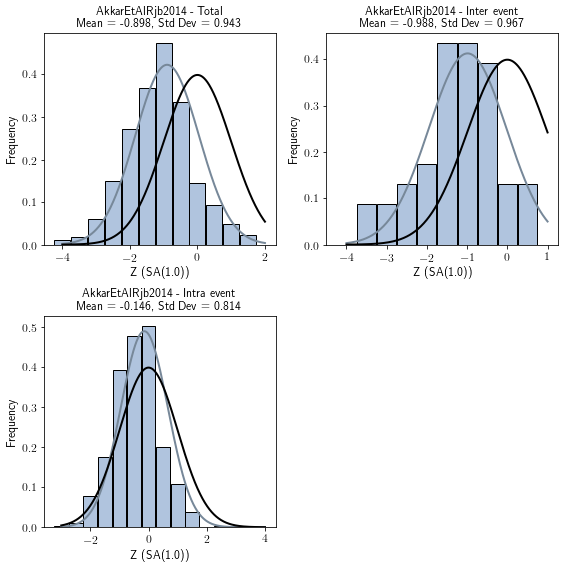

In [14]:
rspl.ResidualPlot(llh, "AkkarEtAlRjb2014", "SA(1.0)", figure_size=(8,8))

If the GSIM were in good agreement with data the residuals follow closely to standard normal distribution. For the intra-event residuals the agreement is not bad. But for the inter-event residuals this is not the case. What other insights could we get?

How does the distribution of residuals compare with magnitude?

Magnitude (Total): a = 0.87826  b = -0.35842  p = 0.00000
Magnitude (Inter event): a = 2.24166  b = -0.71091  p = 0.00220
Magnitude (Intra event): a = -0.35966  b = 0.04312  p = 0.37476


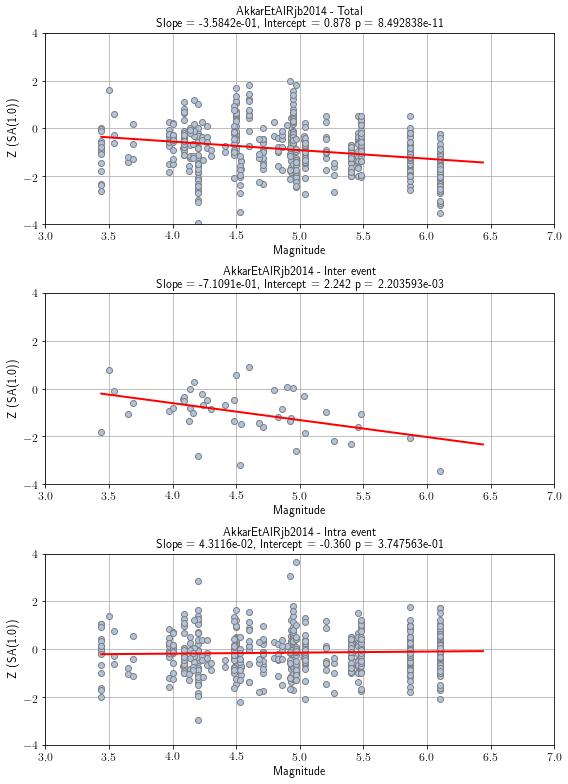

In [8]:
rspl.ResidualWithMagnitude(llh, "AkkarEtAlRjb2014", "SA(1.0)", figure_size=(8, 11))

So, we see a strong negative trend in the inter-event residual with magnitude. It seems the GSIM is overestimating the ground motion for the larger earthquakes.

What about with distance?

Distance (Total): a = -0.51983  b = -0.00165  p = 0.00026
Distance (Inter event): a = -0.08278  b = -0.00447  p = 0.05120
Distance (Intra event): a = -0.28232  b = 0.00060  p = 0.12911


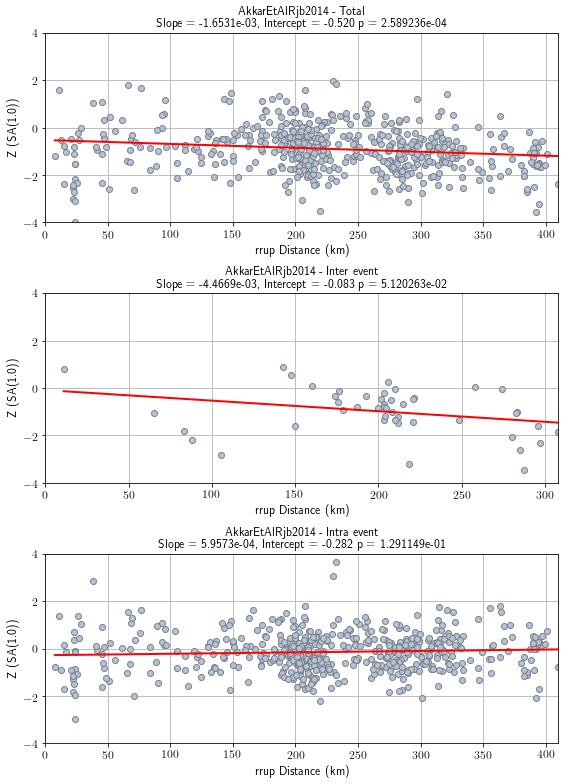

In [9]:
rspl.ResidualWithDistance(llh, "AkkarEtAlRjb2014", "SA(1.0)", figure_size=(8, 11),
                          distance_type="rrup", plot_type="linear")

Generally the trend in intra-event residual with distance is not significant (p > 0.05), implying the GSIM is capturing well the attenuation.

Anything else to look at?

Site (Total): a = -1.20717  b = 0.00041  p = 0.00024
Site (Inter event): a = -0.57965  b = -0.00039  p = 0.30437
Site (Intra event): a = -0.32407  b = 0.00024  p = 0.01440


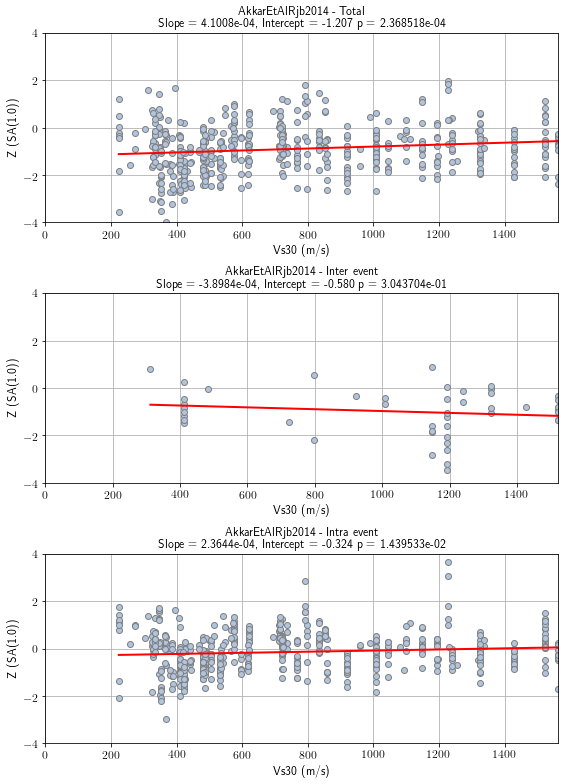

In [10]:
rspl.ResidualWithVs30(llh, "AkkarEtAlRjb2014", "SA(1.0)", figure_size=(8, 11))

This is difficult to interpret. There appears to be only a weak trend in the intra-event residuals with $V_{S30}$ (p < 0.05), but overall the scaling is satisfactory.

### Log-likelihood analysis

Log-likelihood analysis (Scherbaum et al., 2009) and its multivariate extension (Mak et al., 2017), quantify the overall fit of the model to data using information theory. We can see how the model fit changes with period.

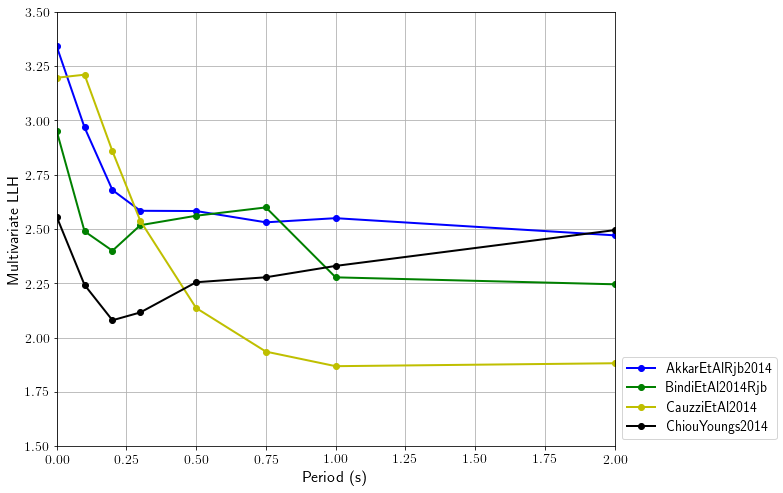

In [13]:
plot_llh_period(llh.get_loglikelihood_values(imts)[0], gsims_shallow, "Multivariate LLH", ylim=(1.5, 3.5))